<a href="https://colab.research.google.com/github/Avenger-py/Polygon-VLM-Challenge/blob/main/polygon_node_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import os

## Utils

In [2]:
import string


def show_image(cv2_img):
    img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()


def puttext_white_bg_new(text, img, org):
    """Put text on image"""
    height, width = img.shape[:2]

    diagonal = np.sqrt(height**2 + width**2)

    thickness_ratio = 0.002

    font_scale = diagonal * 0.0008

    # Calculate thickness based on diagonal
    thickness = max(1, int(diagonal * thickness_ratio))

    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]

    # Calculate the coordinates of the white rectangle
    x, y = org
    width, height = text_size

    x1 = x - int(width * 0.2)
    y1 = y - height - int(height * 0.2)
    x2 = x + width + int(width * 0.2)
    y2 = y + int(height * 0.2)

    # Draw the white rectangle & put text
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), -1)
    cv2.putText(img, text, org, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)



def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))


def detect_edges(image_path, method='canny', vis=False):
    """Canny edge detector """
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Canny edge detection
    # Parameters: image, lower threshold, upper threshold
    # gray = cv2.GaussianBlur(gray, ksize=(3,3), sigmaX=0)
    edges = cv2.Canny(gray, 30, 200)
    edges = cv2.GaussianBlur(edges, ksize=(5,5), sigmaX=0)


    if vis:
        plt.figure(figsize=(12,4))

        # Original image
        plt.subplot(131)
        plt.title('Original Image')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Grayscale image
        plt.subplot(132)
        plt.title('Grayscale')
        plt.imshow(gray, cmap='gray')
        plt.axis('off')

        # Edges
        plt.subplot(133)
        plt.title(f'{method.capitalize()} Edges')
        plt.imshow(edges, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return image, edges



def int_to_alpha(num):
    """Converts an integer to its corresponding alphabetical representation."""

    if not isinstance(num, int) or num < 1:
        raise ValueError("Input must be a positive integer.")

    alphabet = string.ascii_uppercase
    result = ''
    while num > 0:
        num, remainder = divmod(num - 1, 26)  # Adjust for 0-based indexing
        result = alphabet[remainder] + result

    return result

In [ ]:
img1 = cv2.imread("img1.jfif")
img2 = cv2.imread("img2.jfif")
show_image(img1)
show_image(img2)

## Polygon detection

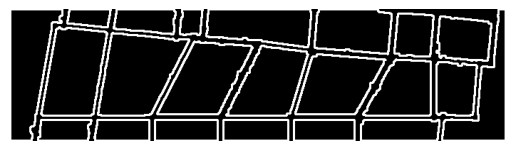

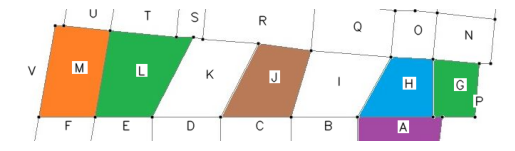

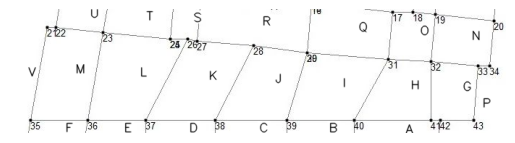

In [4]:
# Detect edges first
image, edges = detect_edges('img1.jfif')
image2 = cv2.imread("img2.jfif")


# Invert edge mask for better contour detection
edges_inverse = ((edges == 0) * 255).astype(np.uint8)
empty_img = np.zeros(edges.shape).astype(edges.dtype)
# show_image(edges_inverse)
contours, _ = cv2.findContours(edges_inverse,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# Save polygon points and label each polygon using alphabets
poly_dict = {}
count = 0
for contour in contours:
    epsilon = 0.04 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    # Only consider countours with corners between 3 and 5
    if len(approx) > 3 and len(approx) <=5:
        count+=1
        # print(len(approx))
        # print(approx.shape)
        cv2.drawContours(empty_img, [contour], 0, [255,255,255], 2)
        # print(count)
        centroid = np.mean(approx[:, 0, :], axis=0).astype(np.int32)
        poly_dict[int_to_alpha(count)] = contour
        puttext_white_bg_new(int_to_alpha(count), image, (centroid[0], centroid[1]))
        puttext_white_bg_new(int_to_alpha(count), image2, (centroid[0], centroid[1]))

show_image(empty_img)
show_image(image)
show_image(image2)

In [22]:
cv2.imwrite("polygon_map_input_img.jpg", image2)
cv2.imwrite("labelled_polygon.jpg", image)

True

## Corner Detection

<ipython-input-6-9e2be96e41bd>:6: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


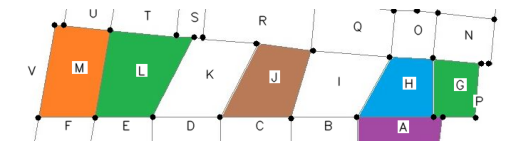

In [6]:
img = cv2.imread('img1.jfif')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


corners = cv2.goodFeaturesToTrack(gray, 30, 0.08, 10)
corners = np.int0(corners)

# Draw the corners on the image
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(image, (x, y), 4, (0, 0, 0), -1)

# Visualize corners
show_image(image)


In [ ]:
# cv2.imwrite("labelled_corners.jpg", image)

True

## Corner to polygon mapping

In [7]:
# Detect and link nodes to each polygon ID
min_dist_threshhold = 15


def corner_to_polygon_mapping(corners, poly_dict, min_dist_threshold):
    """
    Logic:
      If distance between detected polygon point and detected corner point < threshold, then, corner is mapped to that polygon
    Returns:
      Dict: Num corners for each polygon ID

    Note: Fixing number of corner/nodes for each polygon avoids hallucination in VLM later
    """
    corner_count = {}

    for corner in corners:
        point1 = corner.ravel()
        for key in poly_dict:
            # print(poly_dict[key])
            min_dist = float('inf')
            for corner2 in poly_dict[key]:
                point2 = corner2.ravel()
                dist = euclidean_distance(point1, point2)
                if dist < min_dist:
                    min_dist = dist
                    # closest_point = corner2
            if min_dist < min_dist_threshold:
                corner_count[key] = corner_count.get(key, 0) + 1
                # print(euclidean_distance(point1, point2))
            # print(min_dist)

    return corner_count

corner_count = corner_to_polygon_mapping(corners, poly_dict, min_dist_threshhold)
corner_count

{'N': 5,
 'O': 5,
 'P': 5,
 'H': 4,
 'I': 4,
 'Q': 3,
 'K': 5,
 'R': 3,
 'S': 3,
 'G': 5,
 'C': 2,
 'D': 2,
 'J': 4,
 'A': 3,
 'B': 2,
 'M': 5,
 'V': 3,
 'E': 2,
 'L': 5,
 'T': 2,
 'U': 2,
 'F': 2}

### Gemini

In [11]:
import os
os.environ['API_KEY'] = "key"

In [27]:
import google.generativeai as genai
from PIL import Image


def gemini_vision_call(pil_img, prompt):
    genai.configure(api_key=os.environ.get('API_KEY'))
    model = genai.GenerativeModel("gemini-1.5-pro-latest")
    response = model.generate_content([pil_img, prompt])
    try:
        return json.loads(response.text[len("```json"):-len("```")])
    except:
        return response.text


class LLMNodeFinder:
    def __init__(self, labelled_poly_img_pth, polygon_mapped_img_pth, corner_count):
        self.polygon_mapped_img_pth = polygon_mapped_img_pth # image with labelled polygons with nodes
        self.labelled_poly_img_pth = labelled_poly_img_pth # image with labelled polygons without nodes
        self.corner_count = corner_count # number of nodes per polygon

        print("getting node <-> polygon mapping")
        self.node_dict = gemini_vision_call(Image.open(self.polygon_mapped_img_pth), self.get_nodes_prompt(self.corner_count))
        print(self.node_dict)

        self.model = genai.GenerativeModel('gemini-1.5-pro-latest', system_instruction=self.system_node_prompt(self.node_dict))
        print("Ready")

    @staticmethod
    def get_nodes_prompt(corner_count):
        prompt = """You are an expert in solving visual puzzles. You are provided an image:
        1. The image contains polygons labelled using alphabetical IDs like, 'A', 'B', 'C' and so on.
        2. In the image each polygon has numbers written at each vertex or node.

        Here is the exact node count for each polygon:
        """ + str(corner_count) + """

        Task:
        1. Your task is to find and return IDs of all the nodes of each labelled polygon. DO NOT hallucinate.
        2. Count of nodes WILL ALWAYS BE EQUALL to the length of the list of node IDs.
        3. Number of node IDs returned for each polygon can neither be greater or smaller than the count of nodes for that polygon.
        4. You have to be as accurate as possible.


        Procedure:
        1. Refer to the count of nodes in a given polygon given above.
        2. Return the number written next to the nodes.
        3. Verify if number of nodes is equal to the number of numeric node IDs returned.
        4. Repeat for each polygon.


        Tips:
        1. This requires some OCR skill as you need to recognize each numeric text written at the node.
        2. In adjacent polygons, where there is an common edge, some nodes will be common too for both the polygons.
        3. Be aware of overlapping text in the labelling of the nodes.
        4. Be mindful of the positioning of the numeric labelling at the nodes.
        5. All the numeric text written are of two digits.
        6. Polygons are of irregular shape and may have 4, 5, or upto 6 nodes (or even 2 or 3 if the polygon is cropped in the image).

        Response format:
        1. Your response should strictly be in json format. For each alphabetical ID, return list of nodes.
        2. DO NOT output any extra text.
        3. Sample response (not to be taken as actual response):
                        {
                          "W": {
                                "ID": [36, 37, 38, 45],
                              },
                          "Y": {
                              "ID": [46, 50, 51, 52, 53],
                            }
                        }

        """
        return prompt

    @staticmethod
    def system_node_prompt(node_dict):
        prompt = """You are an expert in solving visual puzzles. User will provided you with an image. The image contains polygons labelled using alphabetical
        IDs like, 'A', 'B', 'C' and so on.

        Information:
        For each polygon you are given its corresponding nodes as follows:-
        """ + str(node_dict) + """

        Task:
        1. The user will ask for nodes of a particular polygon. Based on the above shared information you have to return the polygon nodes.
        2. User will use various different ways to identify a particular polygon (color, location, size etc.). You have to map that particular polygon to
           the polygon ID using the image uploaded by the user and then return the nodes corresponding to the polygon ID.
        3. Be as accurate as possible. Do not hallucinate.
        4. Respond in JSON format only.

        Example response:
        USER: "What are the nodes of the blue polygon on extreme left ?
        RESPONSE: {"nodes": 1,2,3,4}

        Now the user will prompt you:

        """
        return prompt

    def find_nodes(self, prompt):
        # prompt = self.system_node_prompt(self.node_dict) + f"\nUSER: {prompt}"
        response = self.model.generate_content([Image.open(self.labelled_poly_img_pth), prompt])
        try:
            return json.loads(response.text[len("```json"):-len("```")])
        except:
            return response.text



node_finder = LLMNodeFinder("labelled_polygon.jpg", "polygon_map_input_img.jpg", corner_count)

getting node <-> polygon mapping
{'A': {'ID': [40, 41, 42]}, 'B': {'ID': [39, 40]}, 'C': {'ID': [38, 39]}, 'D': {'ID': [37, 38]}, 'E': {'ID': [36, 37]}, 'F': {'ID': [35, 36]}, 'G': {'ID': [42, 43, 34, 33, 32]}, 'H': {'ID': [41, 42, 32, 31]}, 'I': {'ID': [39, 40, 31, 30]}, 'J': {'ID': [38, 39, 30, 28]}, 'K': {'ID': [37, 38, 28, 27, 26]}, 'L': {'ID': [36, 37, 26, 25, 23]}, 'M': {'ID': [35, 36, 23, 22, 21]}, 'N': {'ID': [33, 34, 20, 19, 18]}, 'O': {'ID': [32, 33, 19, 18, 17]}, 'P': {'ID': [43, 34, 33, 42, 41]}, 'Q': {'ID': [30, 31, 17]}, 'R': {'ID': [28, 29, 16]}, 'S': {'ID': [25, 26, 27]}, 'T': {'ID': [23, 24]}, 'U': {'ID': [21, 22]}, 'V': {'ID': [35, 21, 20]}}
Ready


In [28]:
node_finder.find_nodes("What are the nodes of the organge polygon?")

{'nodes': [35, 36, 23, 22, 21]}

In [29]:
node_finder.find_nodes("What are the nodes of the purple polygon?")

{'nodes': [40, 41, 42]}

In [32]:
node_finder.find_nodes("What are the nodes of the polygon between the two green polygons?")

{'nodes': [37, 38, 28, 27, 26]}